In [38]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso
import scipy as sp
from scipy.optimize import minimize
from time import time

# Reading and preprocessing data

In [39]:
from data_processing import *
    
# read all data
X, Y, feature_names, receptor_names, protein_names = read_data(design_matrix_file='features_2.csv', 
                                                               activity_file='all_endpoints_with_missing_values_012615.csv')
# omit all features with variance smaller than eps
X, feature_names = remove_constant_features(X, feature_names, eps=1e-2)

Protein names equality check: True


In [40]:
# load selected features
piv = np.load('features_local_cond.npy')
print 'Features to consider:', piv
# find indices of those features in feature_names
piv_ind = np.array([f in piv for f in feature_names])

Features to consider: ['diameter' 'petitjean' 'petitjeanSC' 'weinerPath' 'BCUT_PEOE_1'
 'BCUT_PEOE_3' 'BCUT_SLOGP_0' 'BCUT_SLOGP_1' 'BCUT_SLOGP_2' 'BCUT_SLOGP_3'
 'BCUT_SMR_0' 'GCUT_PEOE_0' 'GCUT_PEOE_1' 'GCUT_PEOE_2' 'GCUT_SLOGP_0'
 'GCUT_SLOGP_1' 'GCUT_SLOGP_2' 'GCUT_SMR_0' 'GCUT_SMR_1' 'GCUT_SMR_2'
 'a_ICM' 'b_1rotN' 'b_1rotR' 'b_double' 'b_rotR' 'b_triple' 'chiral_u'
 'reactive' 'a_nB' 'a_nBr' 'a_nCl' 'a_nF' 'a_nI' 'a_nO' 'a_nP' 'a_nS'
 'FCharge' 'balabanJ' 'PEOE_RPC+' 'PEOE_RPC-' 'PEOE_VSA+0' 'PEOE_VSA+1'
 'PEOE_VSA+2' 'PEOE_VSA+4' 'PEOE_VSA+5' 'PEOE_VSA+6' 'PEOE_VSA-0'
 'PEOE_VSA-1' 'PEOE_VSA-3' 'PEOE_VSA-4' 'PEOE_VSA-5' 'PEOE_VSA-6'
 'PEOE_VSA_FNEG' 'PEOE_VSA_FPNEG' 'PEOE_VSA_FPPOS' 'lip_don' 'lip_druglike'
 'lip_violation' 'opr_leadlike' 'opr_nrot' 'opr_violation' 'Kier3' 'KierA3'
 'KierFlex' 'logS' 'a_acc' 'a_acid' 'a_base' 'vsa_acc' 'vsa_acid'
 'vsa_base' 'vsa_don' 'vsa_other' 'SlogP' 'SlogP_VSA2' 'SlogP_VSA3'
 'SlogP_VSA4' 'SlogP_VSA5' 'SlogP_VSA6' 'SlogP_VSA7' 'SlogP_VSA9'


In [41]:
# select group of tasks to consider
X_k, Y_k = select_tasks(X, Y, receptor_ind=[0, 1, 2])

In [42]:
# split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_k, Y_k, test_size=.5, random_state=100)

#### Counting quality criteria: AUC

In [43]:
def Kfold_cv_Single(clf, X, y, K):
    res = []
    for train_ind, test_ind in KFold(n=X.shape[0], n_folds=K, shuffle=True, random_state=1):
        w = clf.fit(X[train_ind], y[train_ind]).coef_
        y_pred = X[test_ind].dot(w)
        
        temp = roc_auc_score(y[test_ind], y_pred)
        res.append(temp)
     
    return np.array(res).mean()

def Kfold_cv_MTL(clf, X, Y, K):
    res = []
    for train_ind, test_ind in KFold(n=X.shape[0], n_folds=K, shuffle=True, random_state=100):
        W = clf.fit(X[train_ind], Y[train_ind]).coef_.T
        Y_pred = X[test_ind].dot(W)
        
        temp = np.zeros(Y.shape[1])
        for i in range(Y.shape[1]):
            temp[i] = roc_auc_score(Y[test_ind, i], Y_pred[:, i])
        res.append(temp)
     
    return np.array(res).mean(axis=0)

### General problem statement

Given training data $X \in \mathbb{R}^{n \times d}$, and associated class labels $Y \in \mathbb{R}^{n \times c}$, we want to obtain the projection matrix $W \in \mathbb{R}^{d \times c}$, such that

$$Y \approx XW$$

Training data can also be denoted as $(x_i, y_i)_{i=1}^n$ Note that here every $y_i \in \mathbb{R}^c$, which means having multiple labels for each training case.

Problem in general form can be stated as 

$$\min l(XW - Y) + \gamma \Omega(W)$$

In our project we consider either $l(XW - Y) = \| XW - Y \|_{2, 1}$ or $l(XW - Y) = \| XW - Y \|_2^2$.


### Least squares problem with $l_1$ regularization

$$\min_{W} \dfrac{1}{ 2 n } \| XW - Y \|_2^2 + \gamma \| W \|_{2, 1}$$

In [46]:
class MultiTaskLaso:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.coef_ = None
        self.max_iter = max_iter
        self.tol = tol
        self.l1_ratio = 1.0
        
    def coordinate_descent(self, W, l1_reg, l2_reg, X, Y, max_iter, tol):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        n_tasks = Y.shape[1]
        
        gap = tol + 1.0
        d_w_tol = tol
        
        n_iter = 0
        
        norm_cols_X = (X ** 2).sum(axis=0)
        # residuals
        R = Y - np.dot(X, W.T)        
        tol = tol * np.linalg.norm(Y, ord='fro') ** 2
        
        for n_iter in range(max_iter):
            w_max = 0.0
            d_w_max = 0.0
            for f_iter in range(n_features):  # over all coordinates
                ii = f_iter
                if norm_cols_X[ii] == 0.0:
                    continue

                w_ii = W[:, ii] # previous value
                
                if np.sum(w_ii ** 2) != 0.0:  # can do better
                    #R += np.dot(X[:, ii][:, None], w_ii[None, :]) # rank 1 update
                    #print w_ii
                    R += np.dot(X[:, ii][:, None], w_ii[None, :])
                    
                tmp = np.dot(X[:, ii][None, :], R).ravel()
                
                nn = np.sqrt(np.sum(tmp ** 2))

                W[:, ii] = tmp * np.max(1. - l1_reg / nn, 0) / (norm_cols_X[ii] + l2_reg)

                if np.sum(W[:, ii] ** 2) != 0.0:  # can do better
                    R -= np.dot(X[:, ii][:, None], W[:, ii][None, :])
                    # Update residual : rank 1 update

                # update the maximum absolute coefficient update
                d_w_ii = np.max(np.abs(W[:, ii] - w_ii))
                if d_w_ii > d_w_max:
                    d_w_max = d_w_ii

                W_ii_abs_max = np.max(np.abs(W[:, ii]))
                if W_ii_abs_max > w_max:
                    w_max = W_ii_abs_max

            if w_max == 0.0 or d_w_max / w_max < d_w_tol or n_iter == max_iter - 1:
                # maximum update of the coordinate on current step was smaller than tol
                # check the duality gap to determine whether to stop
                
                XtA = np.dot(X.T, R) - l2_reg * W.T
                
                dual_norm_XtA = np.max(np.sqrt(np.sum(XtA ** 2, axis=1)))
                
                R_norm = np.linalg.norm(R, ord='fro')
                w_norm = np.linalg.norm(W, ord='fro')
                
                if (dual_norm_XtA > l1_reg):
                    const =  l1_reg / dual_norm_XtA
                    A_norm = R_norm * const
                    gap = 0.5 * (R_norm ** 2 + A_norm ** 2)
                else:
                    const = 1.0
                    gap = R_norm ** 2

                ry_sum = np.sum(R * Y)
                
                l21_norm = np.sqrt(np.sum(W ** 2, axis=0)).sum()
                
                gap += l1_reg * l21_norm - const * ry_sum + 0.5 * l2_reg * (1 + const ** 2) * (w_norm ** 2)

                if gap < tol:
                    break # reached desired tolerance

        return np.asarray(W), gap, tol, n_iter + 1

    def fit(self, X_train, y_train):        
        y = np.copy(y_train).astype('double')
        X = np.copy(X_train)
        
        # center data to have zero mean along axis=0
        X -= np.mean(X, axis=0)
        y -= np.mean(y, axis=0)
        
        n_samples, n_features = X.shape
        _, n_tasks = y.shape
        
        #X, y, X_mean, y_mean, X_std = center_data(X, y, self.fit_intercept, self.normalize, copy=False)
        
        self.coef_ = np.zeros((n_tasks, n_features), dtype=np.float64)
        
        l1_reg = self.alpha * self.l1_ratio * n_samples
        l2_reg = self.alpha * (1.0 - self.l1_ratio) * n_samples
        
        self.coef_, self.dual_gap_, self.eps_, self.n_iter_ = self.coordinate_descent(
                    self.coef_, l1_reg, l2_reg, X, y, self.max_iter, self.tol)
        
        
        if self.dual_gap_ > self.eps_:
            print 'Did not converge', self.dual_gap_, self.eps_
            
        return self
        
    def predict(self, X_new):
        return X_new.dot(self.coef_.T) #+ self.intercept_

        

In [53]:
start = time()
clf_MTL =MultiTaskLasso(alpha=0.1)
res_MTL = Kfold_cv_MTL(clf_MTL, X_k, Y_k, 10)
time_MTL = time() - start

In [56]:
print 'Run took %.2f seconds' %time_MTL
print 'AUC for all considered tasks: ', res_MTL

Run took 43.09 seconds
AUC for all considered tasks:  [ 0.86029651  0.83281332  0.8471456 ]


In [57]:
clf_MTL = MultiTaskLasso(alpha=0.2)
clf_Single = Lasso(alpha=0.2)

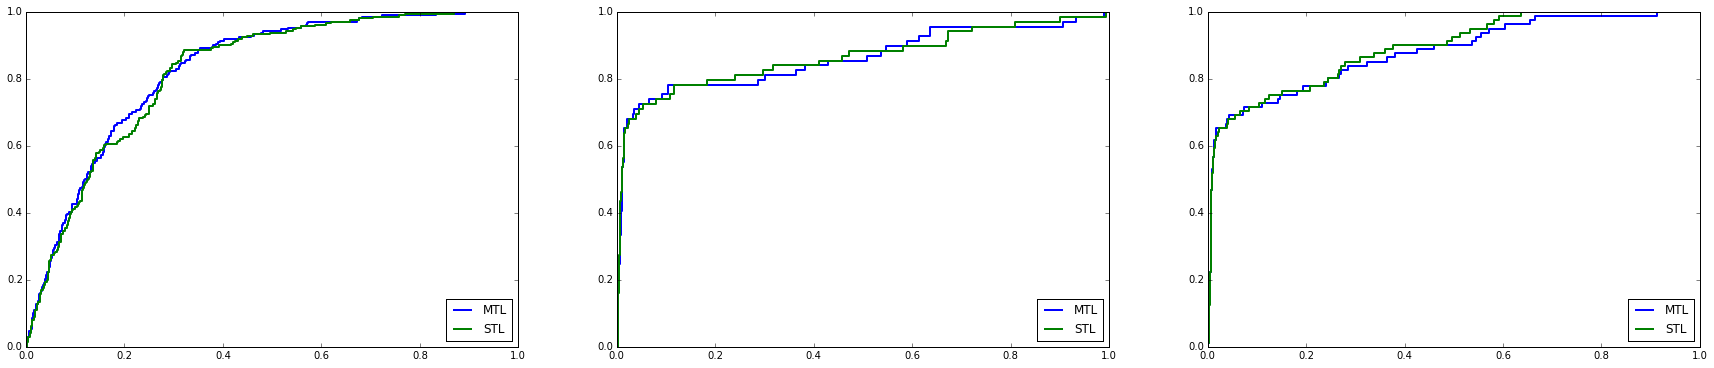

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X_k, Y_k, test_size=.5, random_state=100)

Y_pred = clf_MTL.fit(X_train, Y_train).predict(X_test)
Y_pred_single = np.array([clf_Single.fit(X_train, y).predict(X_test) for y in Y_train.T]).T

fig, ax = plt.subplots(1, 3, figsize=(30, 6))
for i in range(Y_test.shape[1]):
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    ax[i].plot(fpr, tpr, lw=2, label='MTL')
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred_single[:, i])
    ax[i].plot(fpr, tpr, lw=2, label='STL')
    ax[i].legend(loc='lower right')

In [59]:
res_MTL = Kfold_cv_MTL(clf_MTL, X_k, Y_k, 10)
res_Single = np.array([Kfold_cv_Single(clf_Single, X_k, y, 10) for y in Y_k.T])

print res_MTL
print res_Single

[ 0.83843463  0.84011247  0.85901213]
[ 0.83359182  0.85615923  0.87083204]


[0.82817326817768833, 0.86193413910805217, 0.87982740021574968]
[0.82190653930211421, 0.86479491914274531, 0.89208318350713167]


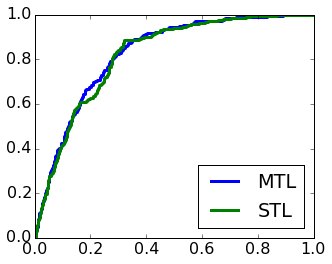

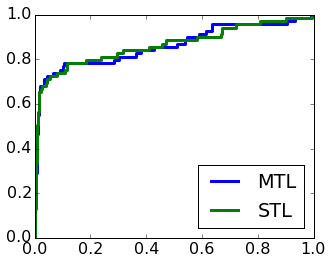

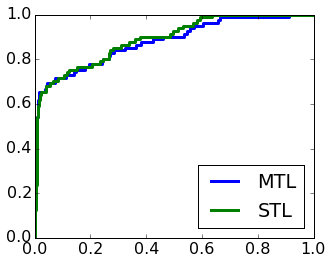

In [60]:
Y_pred = clf_MTL.fit(X_train, Y_train).predict(X_test)
Y_pred_single = np.array([clf_Single.fit(X_train, y).predict(X_test) for y in Y_train.T]).T

import matplotlib
matplotlib.rcParams.update({'font.size': 16})
for i in range(Y_test.shape[1]):
    plt.figure(figsize=(5, 4))
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    plt.plot(fpr, tpr, lw=3, label='MTL')
    fpr, tpr, _ = roc_curve(Y_test[:, i], Y_pred_single[:, i])
    plt.plot(fpr, tpr, lw=3, label='STL')
    plt.legend(loc='lower right')
    plt.savefig('ROC_curves_' + str(i) + '.png', pad_inches=0)

print [roc_auc_score(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])]
print [roc_auc_score(Y_test[:, i], Y_pred_single[:, i]) for i in range(Y_test.shape[1])]

In [61]:
A = np.array([[1, 2, 3],
              [1, 1, 1]])
b = np.array([1, 2])
print A[:, 2][:, None]
print np.dot(A[:, 2][:, None], b[None, :])

[[3]
 [1]]
[[3 6]
 [1 2]]


### Multi-task feature selection

In [62]:
class MTLFeatureSelection():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y  
        self.d = X.shape[1]
        self.m = X.shape[0]
        self.T = Y.shape[1]
        
    def fun(self, w):
        y = self.Y[:, self.task_num]
        return np.sum((y - self.X.dot(w)) ** 2) + self.gamma*np.inner(w, self.D_pinv.dot(w))
       
    def gradient(self, w):
        y = self.Y[:, self.task_num]
        grad = np.zeros(self.d)
        for i in range(self.m):
            grad += ( np.inner(w, self.X[i]) - y[i] ) * self.X[i]
        return 2*grad + 2*self.gamma*self.D_pinv.dot(w)         
        
    
    def Hess(self, w):
        return 2*self.X.T.dot(self.X) + 2*self.gamma*self.D_pinv
    
    def solve(self, gamma = 2, maxiter=1, tol=1e-4):
        self.gamma = gamma
        self.D_pinv = self.d * np.identity(self.d)
        W = np.ones((self.d, self.T))/self.d
        
        it =0
        n_it = 0
        delta_ = np.inf
        while it < maxiter and delta_ > tol:
            for j in range(self.T):
                self.task_num = j
                sol = sp.optimize.minimize(self.fun, W[:, j], jac=self.gradient, hess=self.Hess, method='Newton-CG')
                
                n_it += sol.nit
                w_t = np.array(sol.x).reshape(self.d)
                if np.linalg.norm(W[:, j] - w_t) < delta_:
                    delta_ = np.linalg.norm(W[:, j] - w_t) 
                W[:, j] = w_t
                
            A = sp.linalg.sqrtm(W.dot(W.T))
            self.D_pinv = sp.linalg.pinv(A / np.trace(A)).astype('double')
            it += 1
        self.W = W
        return W, n_it
    
    def predict(self, X_new):
        return X_new.dot(self.W)
       

In [67]:
#myMTLfeat = MTLFeatureSelection(scale(X_k, axis=0), Y_k)
myMTLfeat = MTLFeatureSelection(scale(X_train, axis=0), Y_train)
start = time()
W, n_iter = myMTLfeat.solve(maxiter=1)
time_feat = time() - start

In [70]:
print '%i iterations passed. Run took %.2f sec' %(n_iter, time_feat)

230 iterations passed. Run took 175.00 sec


In [71]:
#Y_pred = myMTLfeat.predict(scale(X_k, axis=0))
Y_pred = myMTLfeat.predict(scale(X_test, axis=0))
#print roc_auc_score(Y_k[:, 0], Y_pred[:, 0])
print [roc_auc_score(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])]

[0.86865653316307734, 0.89232555536903357, 0.86720004794438454]
